In [1]:
import numpy as np
import pandas as pd
import pylab as pl
%pylab inline
from pylab import rcParams
from sklearn import metrics
from operator import itemgetter
from scipy.stats import itemfreq
import re

Populating the interactive namespace from numpy and matplotlib


In [2]:
rcParams['figure.figsize'] = 16,8

## Dataset: IBM stock values from 1962 to 2018

In [3]:
series = pd.Series.from_csv('dataset/ibm_daily_1962-2018.csv', sep='\t',header=0)
series = series["1962-01-02":"2017-12-29"] # Rimuovo il 2018

/Users/francesco/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


### Monthly Line Plot

Per la ricerca di pattern frequenti, la serie storica delle azioni IBM è stata suddivisa in 672 serie mensili, eliminando anche in questo caso il 2018. Come per la fase di clustering, le serie sono state quindi standardizzate (z-score), tuttavia non è stato applicato lo smoothing con media mobile, in quanto ciò avrebbe portato ad una considerevole perdita di dati rispetto alla dimensioni delle serie mensili.

#### Normalization

In [4]:
groups = series.groupby(pd.Grouper(freq='M'))
monthly_list_norm = []
monthly_series_norm = pd.Series()
for name, group in groups:
    group_values = list(group.values)
    scaling_values = (group_values - mean(group_values))/std(group_values)
    monthly_list_norm.append(list(scaling_values))

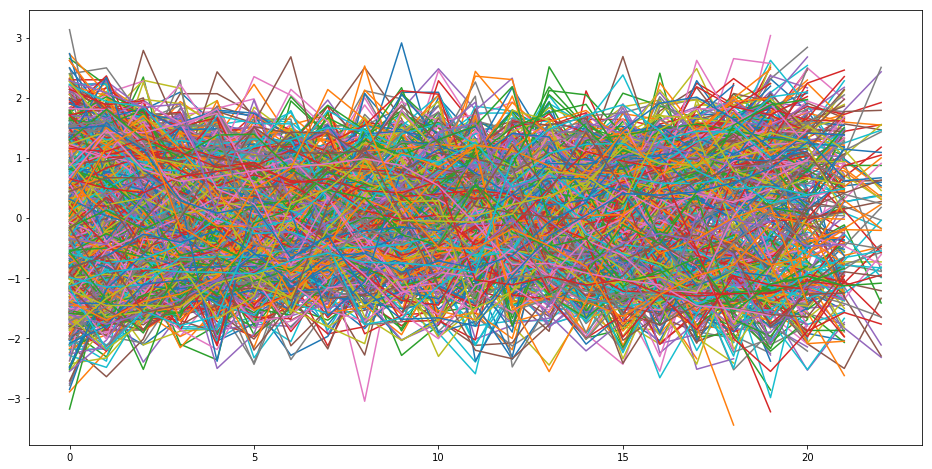

In [5]:
for i in range(len(monthly_list_norm)):
    plt.plot(monthly_list_norm[i])

### Binning sulla serie completa

Gli algoritmi che ricercano i sequential pattern richiedono che la serie sia discretizzata, pertanto
è stato effettuato un binning a larghezza costante (circa 0.6585) sui prezzi normalizzati, utilizzando 10 simboli. La suddivisione in intervalli è stata effettuata riaggregando le serie annuali normalizzate in un’unica serie storica, in modo da ottenere intervalli confrontabili tra loro. 

In [6]:
# Unisco le serie in un'unica lista
list_join = []
for i in range(len(monthly_list_norm)):
    for j in range(len(monthly_list_norm[i])):
        list_join.append(monthly_list_norm[i][j])

In [7]:
# Discretizzo
list_join_binned = list(pd.cut(list_join, 10, labels = False))

In [24]:
forbin = list(pd.cut(list_join, 10))
bins = []
for i in range(len(forbin)):
    if forbin[i] not in bins:
        bins.append(forbin[i])

print("BINS:")
for i in range(len(bins)):
    print(bins[i])
print()
print("BIN WIDTH: ", max((list_join) - min(list_join))/10)

BINS:
(1.156, 1.815]
(0.498, 1.156]
(-0.161, 0.498]
(-0.819, -0.161]
(-1.478, -0.819]
(-2.136, -1.478]
(-3.46, -2.795]
(-2.795, -2.136]
(1.815, 2.474]
(2.474, 3.132]

BIN WIDTH:  0.6585624229595174


In [9]:
# Rifaccio le liste annuali
monthly_list_superbin = []
j = 0
i = 0
month_length = 0
while(i < len(list_join_binned)):
    month = []
    month_length += len(monthly_list_norm[j])
    while(i < month_length):
        month.append(list_join_binned[i])
        i += 1
    monthly_list_superbin.append(month)
    j += 1

### SPMF roundtrip

http://www.philippe-fournier-viger.com/spmf/SPAM.php

In [13]:
# Output per SPMF
input_spam_superbin = open("SPMF_roundtrip/input_spam_superbin.txt",'w')

for j in range(len(monthly_list_superbin)):
    string_series = ""
    for i in range(len(monthly_list_superbin[j])):
        if(i != len(monthly_list_superbin[j])-1):
            string_series = string_series + str(monthly_list_superbin[j][i]) + " -1 "
        else:
            string_series = string_series + str(monthly_list_superbin[j][i]) + " -2"
    print(string_series, file = input_spam_superbin)

Una volta discretizzate le serie, queste sono state nuovamente suddivise per anno, ed è quindi stato possibile utilizzare l’algoritmo SPAM (Sequential PAttern Mining) all’interno del tool Java SPMF. Tra i parametri disponibili si è impostato min-span = 4 e max-gap = 1 in modo da trovare sequenze di minimo quattro giorni consecutivi.
La soglia ottimale di supporto minimo è stata ottenuta empiricamente, diminuendone progressivamente il valore di e osservando la quantità di sottosequenze estratte. Fissando il supporto minimo al 15% si sono trovate 18 sequenze di 4 giorni ciascuna.

In [11]:
f = open('SPMF_roundtrip/output_spam_superbin.txt', 'r')
x = f.readlines()
f.close()

# Calcolo il numero di serie mensili
series_len = 0
for i in range(len(monthly_list_norm)):
    series_len += 1


# Converto l'output di SPMF in una lista
for i in range(len(x)):
    x[i] = x[i].replace("-1", "")
    x[i] = x[i].replace("\n", "")
    x[i] = x[i].replace(" #SUP:", "")
    x[i] = x[i].split("  ")
    for j in range(len(x[i])):
        x[i][j] = int(x[i][j])

# Sposto il supporto in un'altra lista
sup = []
from copy import deepcopy
x_c = deepcopy(x)
for i in range(len(x_c)):
    sup.append(round((x[i][len(x[i])-1])/series_len, 3))
    
for i in range(len(x_c)):
    x[i].pop()
        

# Calcolo la sequenza di lunghezza massima   
max_len = len(x[0])
for i in range(len(x)):
    if (len(x[i]) > max_len):
        max_len = len(x[i])
    
# Riempio le sequenze più brevi con NaN
for i in range(len(x)):
    x[i] = list(np.pad(x[i],(0,max_len-len(x[i])),'constant',constant_values=-3))

for i in range(len(x)):
    for j in range(len(x[i])):
        if(x[i][j] == -3):
            x[i][j] = 'NaN'

# Aggiungo il supporto alla fine di ogni sequenza
for i in range(len(x)):
    x[i].append(sup[i])

# Creo le etichette delle colonne per il dataframe
headers = []
numbers = list(range(10))
for i in range(max_len):
    headers.append(str(numbers[i]))
headers.append("SUP")

In [12]:
seq_pattern = pd.DataFrame(x, columns = headers)
seq_pattern

,0,1,2,3,SUP
0,3,3,3,3,0.171
1,3,3,3,4,0.192
2,3,3,4,4,0.202
3,3,4,4,4,0.182
4,4,3,3,3,0.180
5,4,4,3,3,0.179
6,4,4,4,3,0.186
7,4,4,4,4,0.170
8,5,4,4,4,0.162
9,5,5,5,4,0.156


Dalle sequenze ottenute si può subito notare come i pattern più frequenti contengano variazioni di prezzo molto basse, che coinvolgono infatti al massimo 2 simboli differenti. Inoltre tra i motifs appaiono solo i simboli che rappresentano intervalli centrali, ossia nell’intervallo discretizzato [3, 7] che corrisponde a valori normalizzati tra [-1.478, 1.8149].
Da ciò si può concludere che è molto più probabile nella serie delle azioni IBM avere giorni consecutivi in cui il prezzo varia in maniera ridotta.